In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
sys.path.append(api_path)
# api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
# sys.path.append(api_path)

In [3]:
import numpy as np
import random
import sklearn

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F


from sir_ais_sampling import (run_experiments_gaussians,
                              run_experiments_2_gaussians,
                              sir_correlated_dynamics,
                              sir_independent_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from torch.distributions import (MultivariateNormal, 
                                 Normal, 
                                 Independent, 
                                 Uniform)

from metrics import Evolution
#from utils import DotDict, send_file_to_remote
#from paths import path_to_save_remote, port_to_remote

# SIR, target = 1 gaussian

In [4]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 30000
N = 10
method_params = {'n_steps': n_steps, 'N': N}
random_seed = 42
method = 'sir_independent' 
mode_init = 'target'
print_results = True
results_independent = run_experiments_gaussians(dim_arr,  
                                                scale_proposal, 
                                                scale_target, 
                                                num_points_in_chain, 
                                                strategy_mean,
                                                device,
                                                batch_size,
                                                method_params,
                                                random_seed,
                                                mode_init,
                                                method,
                                                print_results)

------------------
mode = target
dim = 30
mean estimation of variance = 0.9973232746124268
mean estimation of mean = 0.004600784741342068
mean estimation of ess = 0.2613261326132613
------
dim = 60
mean estimation of variance = 1.0435208082199097
mean estimation of mean = 0.008222310803830624
mean estimation of ess = 0.058405840584058406
------
dim = 90
mean estimation of variance = 0.9036582112312317
mean estimation of mean = -0.037323836237192154
mean estimation of ess = 0.0087008700870087
------
dim = 120
mean estimation of variance = 3.863663611269885e-09
mean estimation of mean = -0.043878164142370224
mean estimation of ess = 0.0
------
dim = 150
mean estimation of variance = 3.916035939965923e-09
mean estimation of mean = -0.013066168874502182
mean estimation of ess = 0.0
------
dim = 180
mean estimation of variance = 3.838620088458811e-09
mean estimation of mean = -0.03700427711009979
mean estimation of ess = 0.0
------
dim = 210
mean estimation of variance = 3.790504354839186e-

Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_independent_1_gaussian.pdf to remote server....


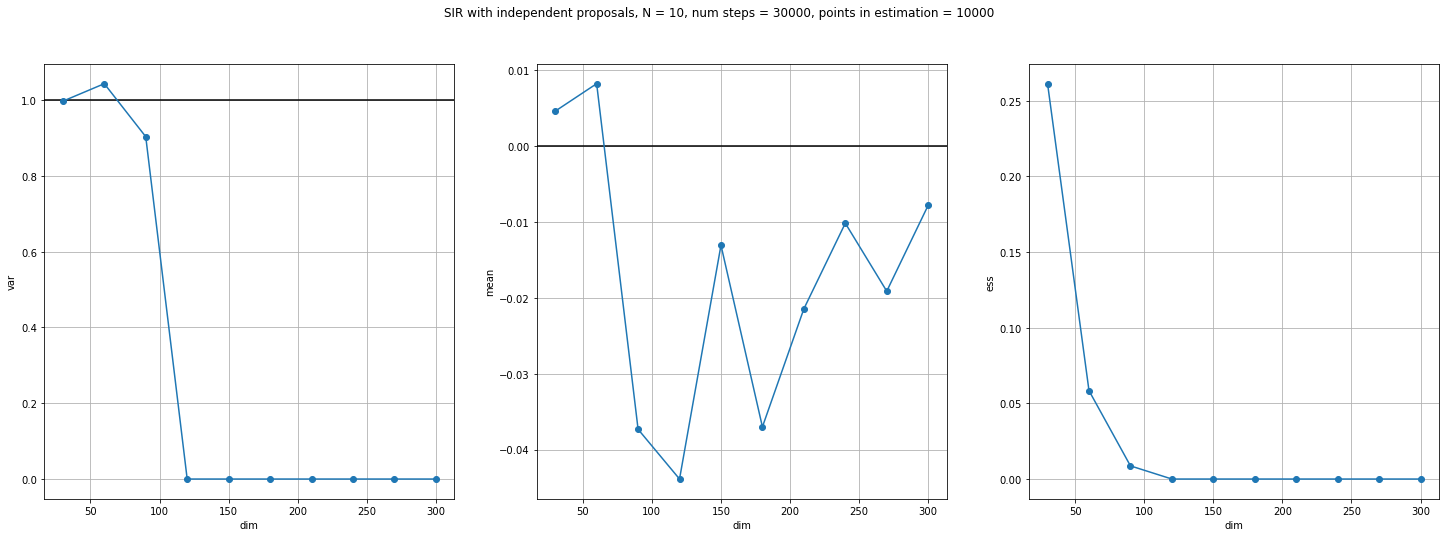

In [78]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25, 8))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(0.0, label='real', color='black')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

#axs[2].axhline(0.0, label='real', color='black')
axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_independent['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_independent['proposal'][mode], label='proposal init', marker='o')
    axs[i].plot(dim_arr, results_independent['target'][mode], marker='o')

for ax in axs:
    ax.grid()
    #ax.legend()

path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_independent_1_gaussian.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote)
plt.show()

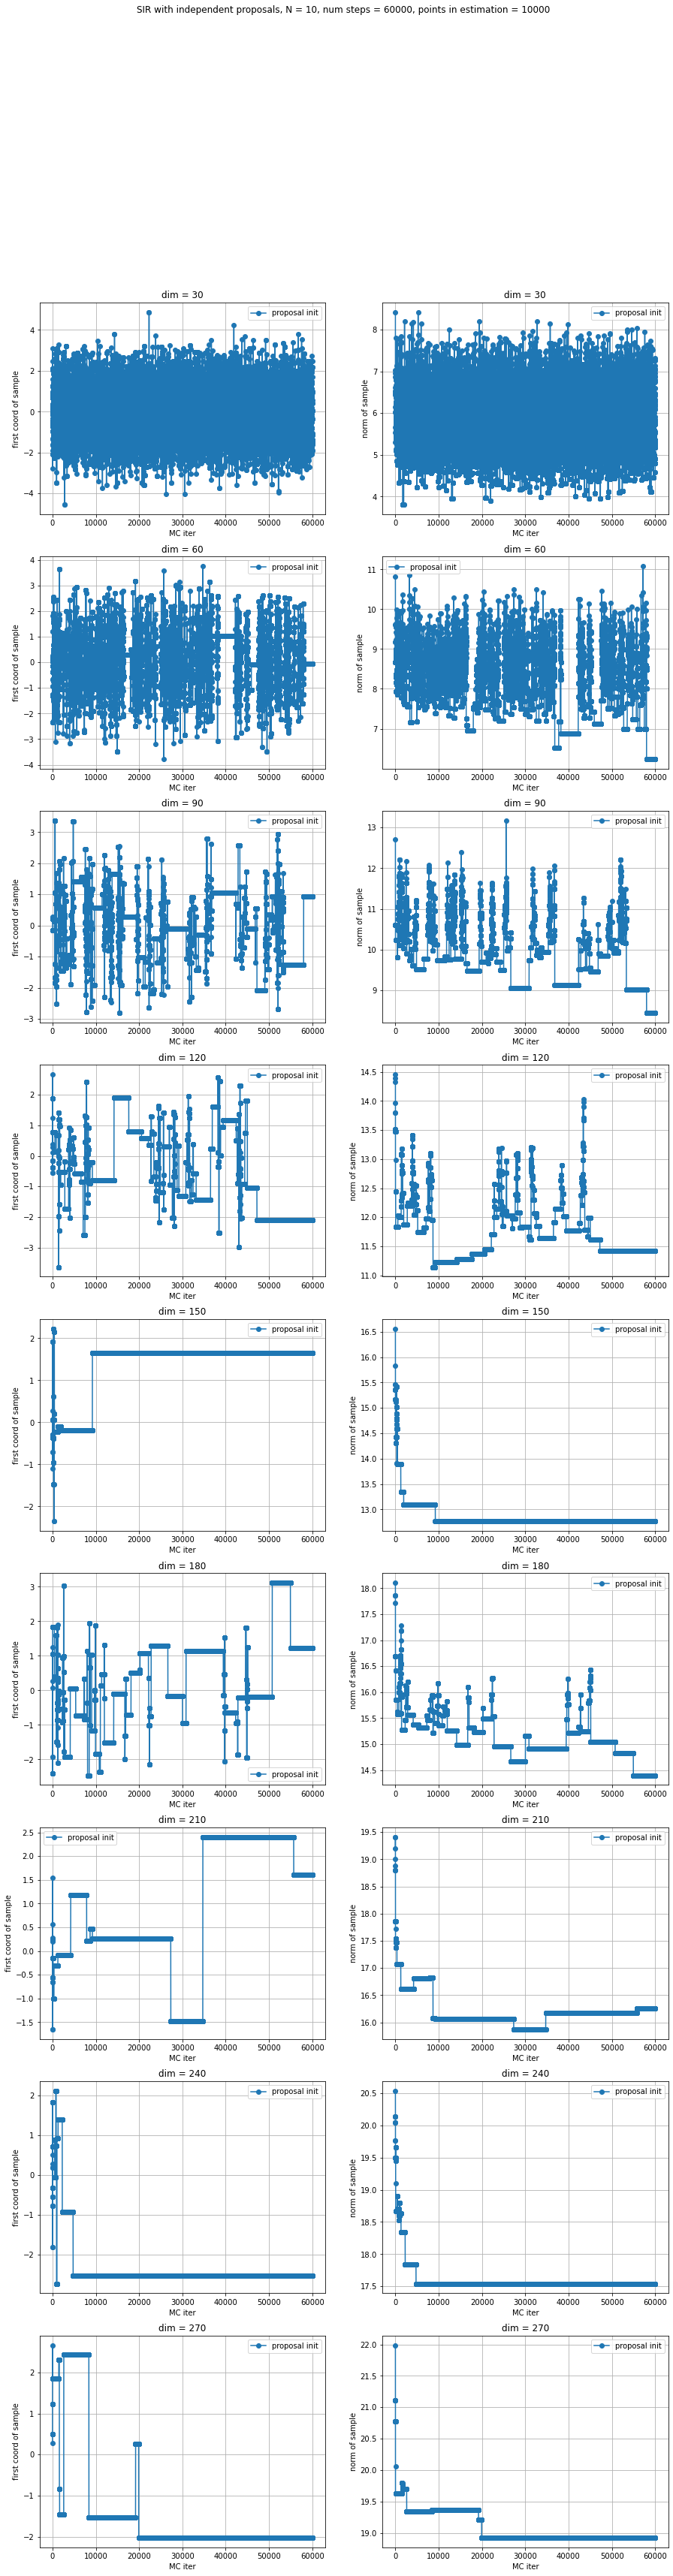

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=len(dim_arr), figsize=(15, 55))
name = f'SIR with independent proposals, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

for i, dim in enumerate(dim_arr):
    axs[i][0].set_xlabel('MC iter')
    axs[i][0].set_ylabel('first coord of sample')
    #axs[i][0].plot(np.arange(len(dict_results['target']['history_first'][i])), 
    #               dict_results['target']['history_first'][i], 
    #               label=f'target init', marker='o')
    axs[i][0].plot(np.arange(len(results_independent['proposal']['history_first'][i])), 
                   results_independent['proposal']['history_first'][i], 
                   label=f'proposal init', marker='o')
    axs[i][0].set_title(f'dim = {dim}')
    axs[i][0].grid()
    axs[i][0].legend()

    axs[i][1].set_xlabel('MC iter')
    axs[i][1].set_ylabel('norm of sample')
    #axs[i][1].plot(np.arange(len(dict_results['target']['history_norm'][i])), 
    #               dict_results['target']['history_norm'][i], 
    #               label='target init', marker='o')
    axs[i][1].plot(np.arange(len(results_independent['proposal']['history_norm'][i])), 
                   results_independent['proposal']['history_norm'][i], 
                   label=f'proposal init', marker='o')
    axs[i][1].set_title(f'dim = {dim}')
    axs[i][1].grid()
    axs[i][1].legend()


plt.show()    

In [5]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
mode_init = 'proposal'
results_corr = run_experiments_gaussians(dim_arr,  
                                         scale_proposal, 
                                         scale_target, 
                                         num_points_in_chain, 
                                         strategy_mean,
                                         device,
                                         batch_size,
                                         method_params,
                                         random_seed,
                                         mode_init,
                                         method,
                                         print_results)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.0070724487304688
mean estimation of mean = -0.017963342368602753
mean estimation of ess = 0.849084908490849
------
dim = 60
mean estimation of variance = 0.9941338300704956
mean estimation of mean = -0.015106490813195705
mean estimation of ess = 0.8454845484548454
------
dim = 90
mean estimation of variance = 0.9752694964408875
mean estimation of mean = -0.030947521328926086
mean estimation of ess = 0.847084708470847
------
dim = 120
mean estimation of variance = 0.9907028079032898
mean estimation of mean = -0.012816584669053555
mean estimation of ess = 0.8453845384538454
------
dim = 150
mean estimation of variance = 0.9856138229370117
mean estimation of mean = -0.019321436062455177
mean estimation of ess = 0.8432843284328433
------
dim = 180
mean estimation of variance = 0.9703444838523865
mean estimation of mean = -0.028816070407629013
mean estimation of ess = 0.8481848184818482
------
dim = 210
mean estimat

Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_1_gaussian.pdf to remote server....


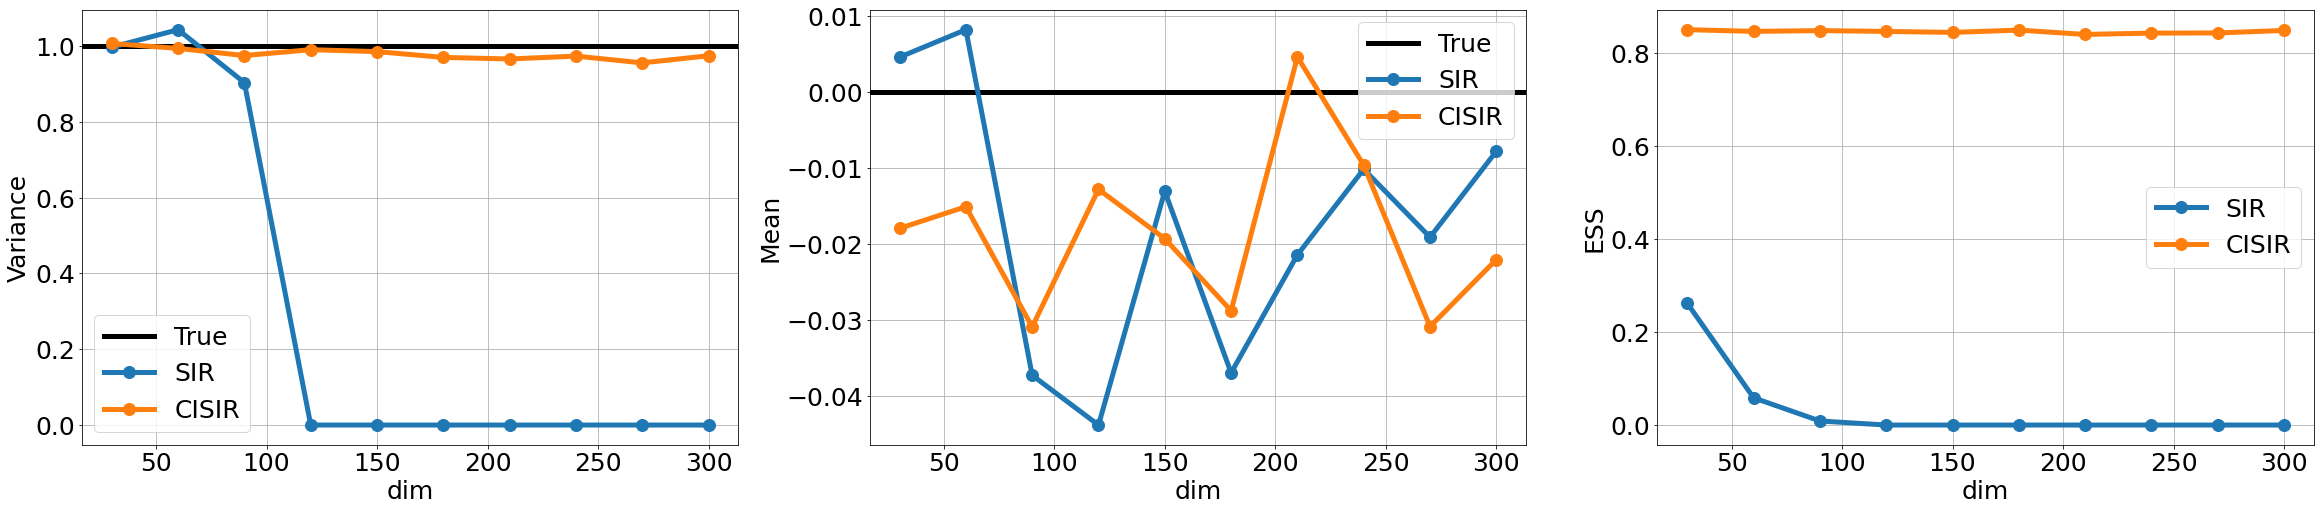

In [51]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
linewidth = 5
markersize = 12

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(40, 8))
#name = f'SIR, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}'
#fig.suptitle(name)

axs[0].axhline(var_target, label='True', color='black', linewidth = linewidth)
axs[0].set_xlabel('dim')
axs[0].set_ylabel('Variance')

axs[1].axhline(0.0, label='True', color='black', linewidth = linewidth)
axs[1].set_xlabel('dim')
axs[1].set_ylabel('Mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS')

modes_to_plot = ['mean_var', 'mean_loc', 'ess']
for i, mode in enumerate(modes_to_plot):
    #axs[i].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
    #axs[i].plot(dim_arr, results_corr['proposal'][mode], label='proposal init', marker='o')
    axs[i].plot(dim_arr, results_independent['target'][mode], label = 'SIR', marker='o',
                markersize = markersize,
                linewidth = linewidth)
    axs[i].plot(dim_arr_corr[:10], results_corr['proposal'][mode][:10], label = 'CISIR', marker='o',
                markersize = markersize,
               linewidth = linewidth)

for ax in axs:
    ax.grid()
    ax.legend()

path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_1_gaussian.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote)    

plt.show()

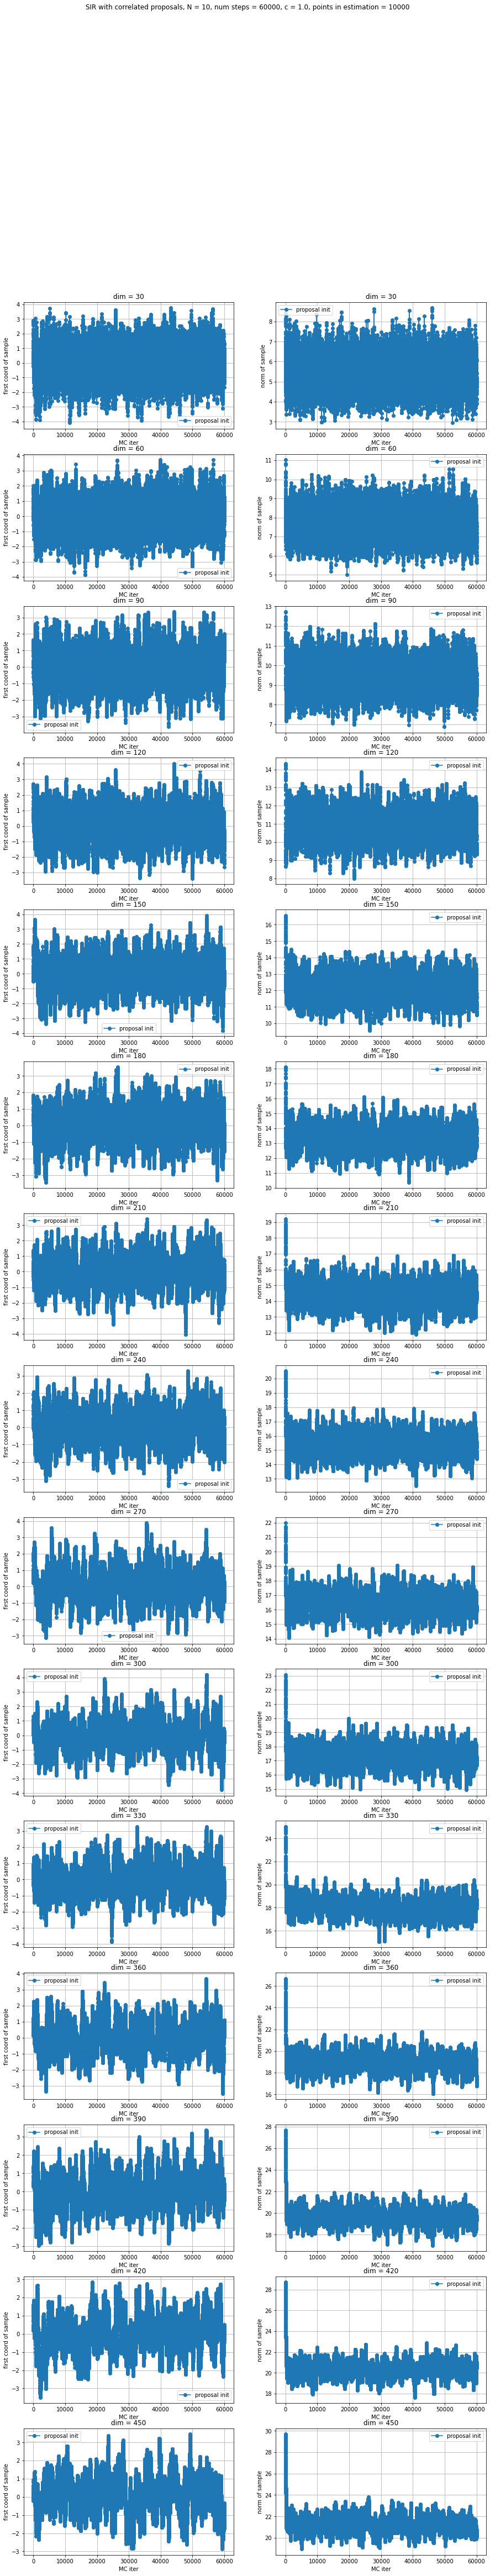

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=len(dim_arr), figsize=(15, 75))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}'
fig.suptitle(name)

for i, dim in enumerate(dim_arr):
    axs[i][0].set_xlabel('MC iter')
    axs[i][0].set_ylabel('first coord of sample')
    axs[i][0].plot(np.arange(len(results_corr['proposal']['history_first'][i])), 
                   results_corr['proposal']['history_first'][i], 
                   label=f'proposal init', marker='o')
    axs[i][0].set_title(f'dim = {dim}')
    axs[i][0].grid()
    axs[i][0].legend()

    axs[i][1].set_xlabel('MC iter')
    axs[i][1].set_ylabel('norm of sample')
    axs[i][1].plot(np.arange(len(results_corr['proposal']['history_norm'][i])), 
                   results_corr['proposal']['history_norm'][i], 
                   label='proposal init', marker='o')
    axs[i][1].set_title(f'dim = {dim}')
    axs[i][1].grid()
    axs[i][1].legend()


plt.show()    

In [81]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 1.0
var_target = 2.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 50000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
print_results = True
mode_init = 'proposal'
results_add = run_experiments_gaussians(dim_arr,  
                                         scale_proposal, 
                                         scale_target, 
                                         num_points_in_chain, 
                                         strategy_mean,
                                         device,
                                         batch_size,
                                         method_params,
                                         random_seed,
                                         mode_init,
                                         method,
                                         print_results)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.9679615497589111
mean estimation of mean = -0.013693430460989475
mean estimation of ess = 0.8473747374737475
------
dim = 60
mean estimation of variance = 1.9376026391983032
mean estimation of mean = 0.0024218917824327946
mean estimation of ess = 0.8488548854885488
------
dim = 90
mean estimation of variance = 1.9066861867904663
mean estimation of mean = 0.007491488475352526
mean estimation of ess = 0.8501650165016501
------
dim = 120
mean estimation of variance = 1.8742953538894653
mean estimation of mean = 0.0036861300468444824
mean estimation of ess = 0.8490849084908489
------
dim = 150
mean estimation of variance = 1.8474078178405762
mean estimation of mean = 0.007857578806579113
mean estimation of ess = 0.8500550055005501
------
dim = 180
mean estimation of variance = 1.8296598196029663
mean estimation of mean = 0.004962598904967308
mean estimation of ess = 0.8501350135013501
------
dim = 210
mean estimati

# SIR, target = 2 gaussians

In [69]:
%autoreload 2

In [6]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_correlated' 
mode_init = 'proposal'
print_results = True
results_corr_2 = run_experiments_2_gaussians(dim_arr,  
                                             scale_proposal, 
                                             scale_target,
                                             loc_1_target,
                                             loc_2_target,
                                             num_points_in_chain, 
                                             strategy_mean,
                                             device,
                                             batch_size,
                                             method_params,
                                             random_seed,
                                             mode_init,
                                             method,
                                             print_results)

------------------
mode = proposal
dim = 30
mean estimation of target variance = 0.9649330345694039
mean estimation of 1 mode mean  = 1.001739740371704
mean estimation of 2 mode mean  = -1.0066263675689697
mean estimation of JSD  = 0.035398959368467334
mean estimation of HQR  = 0.9492499947547912
mean estimation of ESS = 0.7905590559055906
------
dim = 60
mean estimation of target variance = 0.9684273057532629
mean estimation of 1 mode mean  = 0.997853696346283
mean estimation of 2 mode mean  = -1.0056425333023071
mean estimation of JSD  = 0.03554243594408035
mean estimation of HQR  = 0.9503100037574768
mean estimation of ESS = 0.7908890889088909
------
dim = 90
mean estimation of target variance = 0.9752672240779294
mean estimation of 1 mode mean  = 0.9903038740158081
mean estimation of 2 mode mean  = -1.0032496452331543
mean estimation of JSD  = 0.03547200188040733
mean estimation of HQR  = 0.9497600018978118
mean estimation of ESS = 0.7934193419341935
------
dim = 120
mean estimatio

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_correlated_2_gaussians.pdf to remote server....


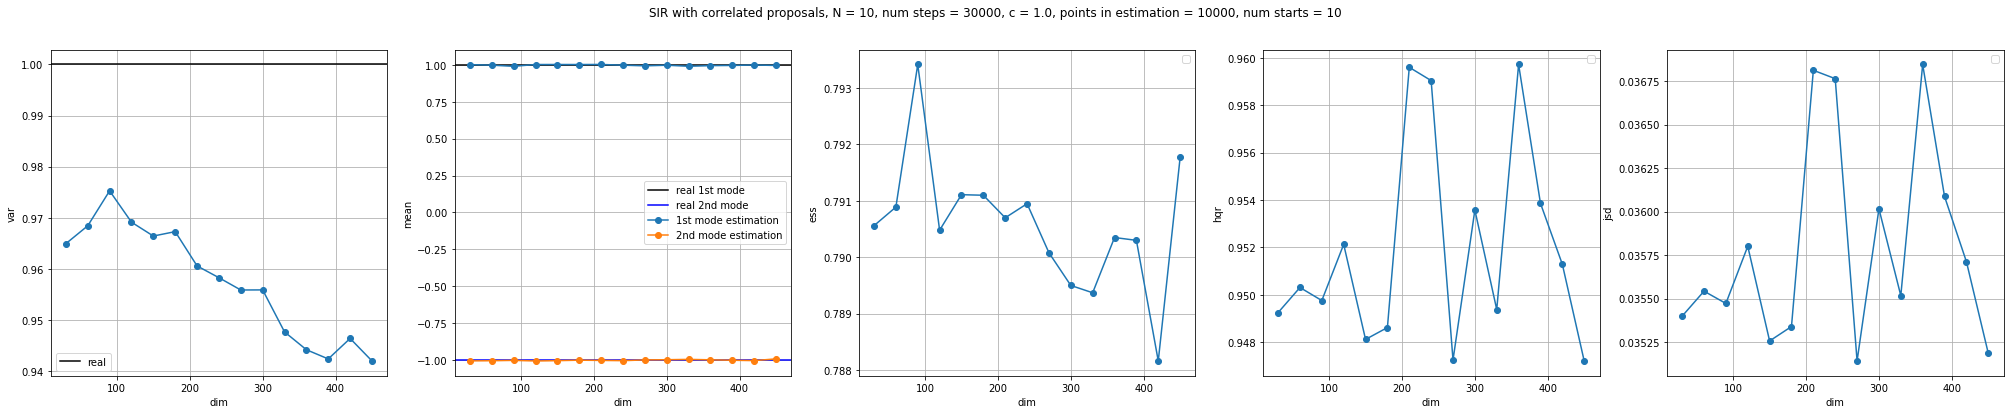

In [71]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(35, 6))
name = f'SIR with сorrelated proposals, N = {N}, num steps = {n_steps}, c = {c}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
fig.suptitle(name)

axs[0].axhline(var_target, label='real', color='black')
axs[0].set_xlabel('dim')
axs[0].set_ylabel('var')

axs[1].axhline(loc_1_target, label='real 1st mode', color='black')
axs[1].axhline(loc_2_target, label='real 2nd mode', color='blue')
axs[1].set_xlabel('dim')
axs[1].set_ylabel('mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ess')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('hqr')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('jsd')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_1'], 
        #            label='target init, 1st mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr_2['proposal']['mean_loc_1'], 
                    label='1st mode estimation', marker='o')
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
        #            label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr, results_corr_2['proposal']['mean_loc_2'], 
                    label='2nd mode estimation', marker='o')
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        #axs[j].plot(dim_arr, results_corr['target'][mode], label='target init', marker='o')
        axs[j].plot(dim_arr, results_corr_2['proposal'][mode], marker='o')
    
for ax in axs:
    ax.grid()
    ax.legend()
    
path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_correlated_2_gaussians.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote) 

plt.show()

In [7]:
dim_arr = [30*(i + 1) for i in range(10)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
loc_1_target = 1.0
loc_2_target = -1.0

num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
n_steps = 30000
c = 1.0
N = 10
method_params = {'n_steps': n_steps, 'scale_proposal': scale_proposal, 'N': 10, 'c': c}
random_seed = 42
method = 'sir_independent' 
mode_init = 'target'
print_results = True
results_independent_2 = run_experiments_2_gaussians(dim_arr,  
                                                    scale_proposal, 
                                                    scale_target,
                                                    loc_1_target,
                                                    loc_2_target,
                                                    num_points_in_chain, 
                                                    strategy_mean,
                                                    device,
                                                    batch_size,
                                                    method_params,
                                                    random_seed,
                                                    mode_init,
                                                    method,
                                                    print_results)

------------------
mode = target
dim = 30
mean estimation of target variance = 0.5177300910103673
mean estimation of 1 mode mean  = 0.8630160093307495
mean estimation of 2 mode mean  = -0.8818822503089905
mean estimation of JSD  = 0.044360130093991756
mean estimation of HQR  = 0.9425499975681305
mean estimation of ESS = 0.0037703770377037703
------
dim = 60
mean estimation of target variance = 7.373292264391776e-14
mean estimation of 1 mode mean  = 0.9944514036178589
mean estimation of 2 mode mean  = -1.0214898586273193
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 90
mean estimation of target variance = 7.426876359800128e-14
mean estimation of 1 mode mean  = 1.01462721824646
mean estimation of 2 mode mean  = -0.9778567552566528
mean estimation of JSD  = 0.04247488081455231
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.0
------
dim = 120
mean estimation of target variance = 7.118772735836129e-14
mean est

In [9]:
dim_arr_corr = [30*(i + 1) for i in range(15)]

Try to send file /home/daniil/gans-mcmc/known_target_experiment/plots/sir_2_gaussians.pdf to remote server....


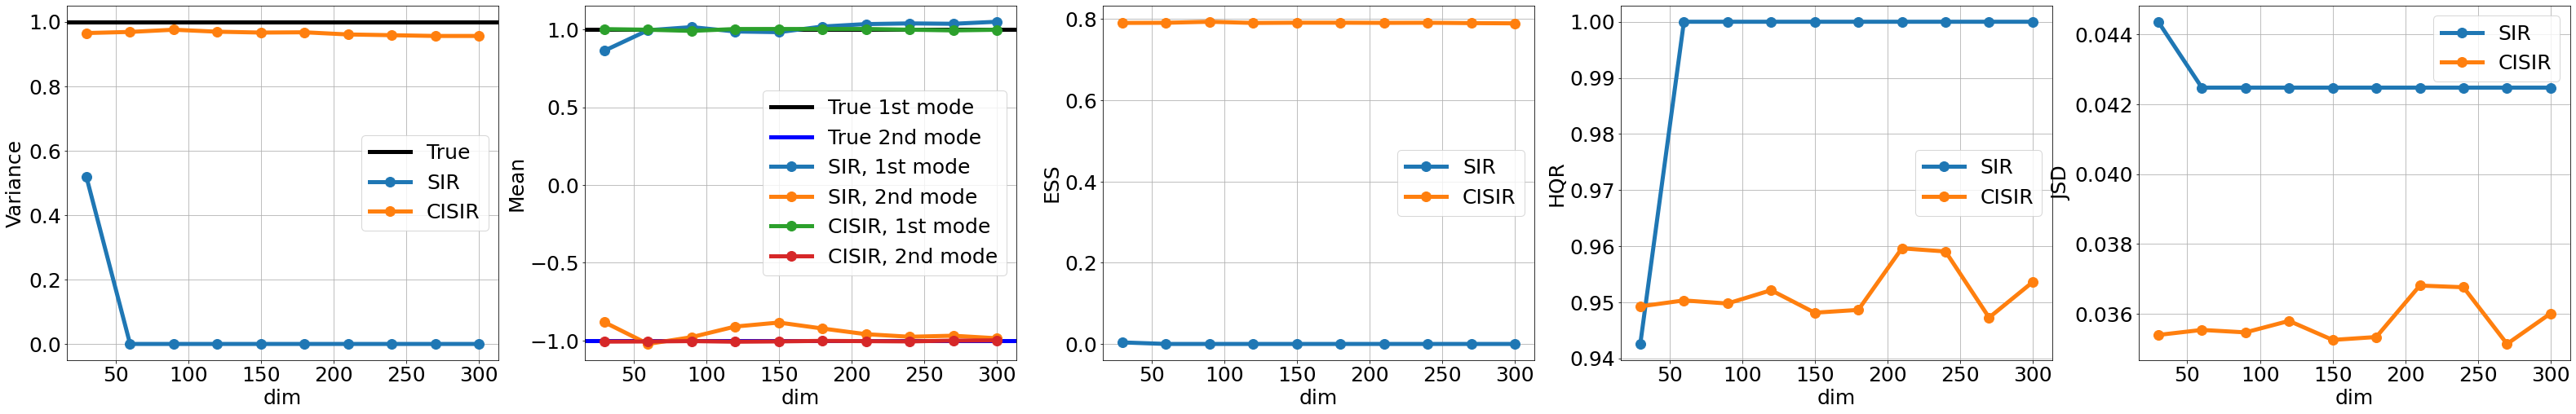

In [50]:
plt.rcParams.update({'font.size': 25})
linewidth = 5
markersize = 12

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(55, 8))
#name = f'SIR, N = {N}, num steps = {n_steps}, points in estimation = {num_points_in_chain}, num starts = {batch_size}'
#fig.suptitle(name)

axs[0].axhline(var_target, label='True', color='black', linewidth = linewidth)
axs[0].set_xlabel('dim')
axs[0].set_ylabel('Variance')

axs[1].axhline(loc_1_target, label='True 1st mode', color='black', linewidth = linewidth)
axs[1].axhline(loc_2_target, label='True 2nd mode', color='blue', linewidth = linewidth)
axs[1].set_xlabel('dim')
axs[1].set_ylabel('Mean')

axs[2].set_xlabel('dim')
axs[2].set_ylabel('ESS')

axs[3].set_xlabel('dim')
axs[3].set_ylabel('HQR')

axs[4].set_xlabel('dim')
axs[4].set_ylabel('JSD')

modes_to_plot = ['mean_var', 'mean_loc_1', 'mean_loc_2', 'ess', 'mean_hqr', 'mean_jsd']
for i, mode in enumerate(modes_to_plot):
    if i == 1:
        axs[i].plot(dim_arr, results_independent_2['target']['mean_loc_1'], 
                    label='SIR, 1st mode', marker='o', linewidth = linewidth, 
                   markersize = markersize )
        axs[i].plot(dim_arr, results_independent_2['target']['mean_loc_2'], 
                    label='SIR, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        axs[i].plot(dim_arr_corr[:10], results_corr_2['proposal']['mean_loc_1'][:10], 
                    label='CISIR, 1st mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
        #axs[i].plot(dim_arr, results_corr['target']['mean_loc_2'], 
        #            label='target init, 2nd mode estimation', marker='o')
        axs[i].plot(dim_arr_corr[:10], results_corr_2['proposal']['mean_loc_2'][:10], 
                    label='CISIR, 2nd mode', marker='o', linewidth = linewidth,
                   markersize  = markersize )
    elif i == 2:
        pass
    else:
        if i == 0:
            j = 0
        else:
            j = i - 1
        axs[j].plot(dim_arr, results_independent_2['target'][mode], 
                    label='SIR', marker='o', linewidth = linewidth,
                   markersize  = markersize)
        axs[j].plot(dim_arr_corr[:10], results_corr_2['proposal'][mode][:10], 
                    label='CISIR', marker='o', linewidth = linewidth,
                   markersize  = markersize)
    
for ax in axs:
    ax.grid()
    ax.legend()
    
path_to_plots = '/home/daniil/gans-mcmc/known_target_experiment/plots'
path_to_fig = os.path.join(path_to_plots, 'sir_2_gaussians.pdf')
plt.savefig(path_to_fig)
send_file_to_remote(path_to_fig,
                    port_to_remote, 
                    path_to_save_remote) 

plt.show()

# AIS

In [4]:
def grad_energy(point, target, x=None):
    point = point.detach().requires_grad_()
    if x is not None:
        energy = -target.log_prob(z=point, x=x)
    else:
        energy = -target.log_prob(point)
    grad = torch.autograd.grad(energy.sum(), point)[0]
    return energy, grad

In [8]:
def compute_log_probs(point1, point2, target, proposal, beta, grad_step, eps_scale):
    E_point1, grad_point1 = grad_energy(point1, target, x=None)
    E_point2, grad_point2 = grad_energy(point2, target, x=None)
    
    energy_part = beta*(E_point1 - E_point2)
    
    propose_vec_1 = point1 - (1. - grad_step)*point2 + grad_step*beta*point2
    propose_vec_2 = point2 - (1. - grad_step)*point1 + grad_step*beta*grad_point1
    
    propose_part_1 = proposal.log_prob(propose_vec_1/eps_scale)
    propose_part_2 = proposal.log_prob(propose_vec_2/eps_scale)
    propose_part = propose_part_1 - propose_part_2
    
    log_probs = propose_part + energy_part
    return (E_point1.detach().clone(), 
            grad_point1.detach().clone(), 
            E_point2.detach().clone(), 
            grad_point2.detach().clone(), 
            log_probs.detach().clone())

def compute_probs_from_log_probs(log_probs):
    mask_zeros = log_probs > 0.
    num_big_zeros = mask_zeros.sum().item()
    log_probs[mask_zeros] = torch.zeros(num_big_zeros, 
                                        dtype = log_probs.dtype).to(log_probs.device)
    probs = log_probs.exp()
    return probs

def ais_dynamics(z, target, proposal, n_steps, N, betas, rhos, grad_step, eps_scale):
    #z - tensor (bs, T + 1, dim)
    z_sp = []
    batch_size, T, z_dim = z.shape[0], z.shape[1], z.shape[2]
    T = T - 1
    uniform = Uniform(low = 0.0, high = 1.0)
    
    for _ in range(n_steps):
        #print(f"iter = {_}")
        z_sp.append(z.detach().clone())
        v = torch.zeros((batch_size, T + 1, N, z_dim), dtype = z.dtype).to(z.device)
        u = torch.zeros((batch_size, T + 1, N), dtype = z.dtype).to(z.device)
        #print("step1")
        #step 1
        kappa = torch.zeros((batch_size, T + 1, z_dim), dtype = z.dtype).to(z.device)
        
        kappa_t_noise = proposal.sample([batch_size, T + 1])
        
        kappa[:, 0, :] = rhos[0]*z[:, 0, :] + ((1 - rhos[0]**2)**0.5) * kappa_t_noise[:, 0, :]
        
        for t in range(1, T + 1):
            #print(f"t = {t}")
            not_equal_mask = (torch.norm(z[:, t, :] - z[:, t - 1, :], p=2, dim=-1) > 1e-13)
            equal_mask = ~not_equal_mask             
            
            num_not_equal = not_equal_mask.sum()
            num_equal = equal_mask.sum()
            #print(f"num_not_equal = {num_not_equal}")
            #print(f"num_equal = {num_equal}")
            
            if num_not_equal > 0:
                #print(f"start to do updates for not equal batches")
                z_t_not_equal = z[not_equal_mask, t, :].detach().clone()
                z_t_1_not_equal = z[not_equal_mask, t - 1, :].detach().clone()
                #print(z_t_not_equal.shape)
                z_t_not_equal.requires_grad_(True)
                z_t_1_not_equal.requires_grad_(True)
                
                E_point1, grad_point1, E_point2, grad_point2, log_probs = compute_log_probs(z_t_1_not_equal, 
                                                                                            z_t_not_equal, 
                                                                                            target, 
                                                                                            proposal, 
                                                                                            betas[t], 
                                                                                            grad_step, 
                                                                                            eps_scale)

                v[not_equal_mask, t, 0, :] = (z_t_not_equal - (1. - grad_step)*z_t_1_not_equal \
                                                            + grad_step*betas[t]*grad_point1)/eps_scale
                #print(log_probs.shape)
                probs = compute_probs_from_log_probs(log_probs)
                generate_uniform_var = uniform.sample([probs.shape[0]]).to(probs.device)
                weight_uniform_var = generate_uniform_var * probs

                u[not_equal_mask, t, 0] = weight_uniform_var
            
            if num_equal > 0:
                #print(f"start to do updates for equal batches")
                z_t_equal = z[equal_mask, t, :]
                z_t_1_equal = z[equal_mask, t - 1, :].detach().clone()
                z_t_1_equal.requires_grad_(True)
                
                E_t_1_equal, grad_t_1_equal = grad_energy(z_t_1_equal, target, x=None)
                
                second_part_no_noise = (1. - grad_step)*z_t_1_equal - grad_step*betas[t]*grad_t_1_equal

                stop = False
                num_updates = 0
                update_mask = torch.zeros(num_equal, dtype = torch.bool).to(z_t_equal.device)
                #print(f"update_mask.sum() = {updates_num}")
                z_t_1_equal = z_t_1_equal.detach().clone()
                z_t_1_equal.requires_grad_(True)
                #print("start to while sampling")
                while not stop:
                    cur_u = uniform.sample([num_equal]).to(z_t_equal.device)
                    cur_v = proposal.sample([num_equal]).to(z_t_equal.device)
                    second_part = second_part_no_noise + cur_v*eps_scale
                    second_part = second_part.detach().clone()
                    second_part.requires_grad_(True)
                    
                    _, _, _, _, log_probs = compute_log_probs(z_t_1_equal, 
                                                              second_part, 
                                                              target, 
                                                              proposal, 
                                                              betas[t], 
                                                              grad_step, 
                                                              eps_scale)
                    probs = compute_probs_from_log_probs(log_probs)
                    mask_assign = (cur_u > probs)
                    new_assign = torch.logical_and(mask_assign, ~update_mask) 
                    #print(new_assign.shape)
                    #print(u.shape)
                    #print(cur_u.shape)
                    
                    u[equal_mask, t, 0][new_assign] = cur_u[new_assign]
                    v[equal_mask, t, 0, :][new_assign] = cur_v[new_assign]
                    
                    
                    update_mask = torch.logical_or(update_mask, new_assign)
                    updates_num = update_mask.sum()
                    
                    #print(f"update_mask = {updates_num}")
                    
                    
                    if updates_num == num_equal:
                        stop = True
            
            kappa[:, t, :] = rhos[t]*v[:, t, 0, :] + ((1 - rhos[t]**2)**0.5) * kappa_t_noise[:, t, :]
        #print("end step 1")   
        #print("step2")
        #step 2
        W = proposal.sample([batch_size, N - 1])
        #Z - tensor (bs, T + 1, N, dim)
        Z = torch.zeros((batch_size, T + 1, N, z_dim), dtype = z.dtype).to(z.device)
        kappa_repeat = kappa[:, 0, :].unsqueeze(1).repeat(1, N - 1, 1)
        kappa_N_noise = proposal.sample([batch_size, N - 1])
        #print(z_repeat.shape)
        #print(W.shape)
        Z[:, :, 0, :] = z
        Z[:, 0, 1:, :] = rhos[0]*kappa_repeat + ((1 - rhos[0]**2)**0.5) * kappa_N_noise
        
        kappa_repeat_N = kappa.unsqueeze(2).repeat(1, 1, N - 1, 1)
        W_2 = proposal.sample([batch_size, T, N - 1])
        
        for t in range(1, T + 1):
            #print(f"t = {t}")
            v[:, t, 1:, :] = rhos[t]*kappa_repeat_N[:, t - 1, :, :] + ((1 - rhos[t]**2)**0.5) * W_2[:, t - 1, :, :]
            z_t_1_j_shape = Z[:, t - 1, 1:, :].shape
            z_t_1_j_flatten = Z[:, t - 1, 1:, :].reshape(-1, z_dim).detach().clone()
            z_t_1_j_flatten.requires_grad_(True)
            
            _, grad_z_t_1_j_flatten = grad_energy(z_t_1_j_flatten, target, x=None)
            grad_z_t_1_j = grad_z_t_1_j_flatten.reshape(z_t_1_j_shape)
            p_t_j = (1. - grad_step)*Z[:, t - 1, 1:, :] - grad_step*betas[t]*grad_z_t_1_j \
                                                    + eps_scale*v[:, t, 1:, :]
            Z_t_1_j = Z[:, t - 1, 1:, :]
            Z_t_1_j_shape = Z_t_1_j.shape
            
            p_t_j_flatten = p_t_j.view(-1, z_dim).detach().clone()
            p_t_j_flatten.requires_grad_(True)
            
            Z_t_1_j_flatten = Z_t_1_j.reshape(-1, z_dim).detach().clone()
            Z_t_1_j_flatten.requires_grad_(True)
            
            _, _, _, _, log_probs = compute_log_probs(Z_t_1_j_flatten, 
                                                      p_t_j_flatten, 
                                                      target, 
                                                      proposal, 
                                                      betas[t], 
                                                      grad_step, 
                                                      eps_scale)
            probs_flatten = compute_probs_from_log_probs(log_probs)
            probs = probs_flatten.view(batch_size, N - 1)
            u_t_1 = u[:, t, 0].unsqueeze(1).repeat(1, N - 1)
            
            mask_leq = (u_t_1 <= probs)
            mask_ge = ~mask_leq
            
            mask_leq_big = mask_leq.unsqueeze(-1).repeat(1, 1, z_dim)
            mask_ge_big = mask_ge.unsqueeze(-1).repeat(1, 1, z_dim)
            
            Z[:, t, 1:, :][mask_leq_big] = p_t_j[mask_leq_big]
            Z[:, t, 1:, :][mask_ge_big] = Z[:, t - 1, 1:, :][mask_ge_big]
            
        #Z[:, :, 0, :] = z
        #print("end step2")
        #print("start step3")
        log_weights = torch.zeros((T, batch_size, N), dtype = z.dtype).to(z.device)
        for t in range(1, T + 1):
            cur_z = Z[:, t - 1, :, :]
            
            z_flatten = cur_z.reshape(-1, z_dim)
            E_flatten = -target.log_prob(z_flatten)
            
            E = E_flatten.reshape((batch_size, N))
            
            log_weights[t - 1, :, :] = -(betas[t] - betas[t - 1])*E
            
        
        log_weights = log_weights.sum(axis = 0)
        max_logs = torch.max(log_weights, dim = 1)[0].unsqueeze(-1).repeat((1, N))
        log_weights = log_weights - max_logs
        weights = torch.exp(log_weights)
        sum_weights = torch.sum(weights, dim = 1)
        weights = weights/sum_weights[:, None]

        weights[weights != weights] = 0.
        weights[weights.sum(1) == 0.] = 1.
        
        indices = torch.multinomial(weights, 1).squeeze().tolist()
        z[:, :, :] = Z[np.arange(batch_size), :, indices, :]
        
        #print("end step4")
        
    z_sp.append(z.detach().clone()) 
    return z_sp

In [5]:
from easydict import EasyDict as edict

dim = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loc_proposal = torch.zeros(dim).to(device)
scale_proposal = torch.ones(dim).to(device)
proposal_args = edict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

loc_target = torch.zeros(dim).to(device)
scale_target = 2*torch.ones(dim).to(device)
target_args = edict()
target_args.device = device
target_args.loc = loc_target
target_args.scale = scale_target
target = IndependentNormal(target_args)

n_steps = 10
grad_step = 1e-2
eps_scale = (2*grad_step)**0.5

T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
rhos = torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

N = 10

batch_size = 5

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

start = proposal.sample([batch_size, T + 1])

In [13]:
ais_dynamics_arr = ais_dynamics(start, target, proposal, n_steps, N, betas, rhos, grad_step, eps_scale)

In [15]:
def run_experiments_gaussians(dim_arr,  
                              scale_proposal, 
                              scale_target, 
                              num_points_in_chain, 
                              strategy_mean,
                              device,
                              batch_size,
                              method_params,
                              random_seed=42,
                              mode_init='proposal',
                              method='sir_independent',
                              print_results=True):
    dict_results = {mode_init: {'mean_loc': [], 'mean_var': [], 
                               'ess': [], 'history_first': [], 
                                          'history_norm': []}}
   
    if print_results:
       print("------------------")
       print(f"mode = {mode_init}")
    
    for dim in dim_arr:
       if print_results:
          print(f"dim = {dim}")
       target = init_independent_normal(scale_target, dim, device)
       proposal = init_independent_normal(scale_proposal, dim, device)
       torch.manual_seed(random_seed)
       np.random.seed(random_seed)
       random.seed(random_seed)
    
       if (mode_init == 'target') and (method != 'ais'):
          start = target.sample([batch_size])
       elif mode_init == 'proposal' and (method != 'ais'):
          start = proposal.sample([batch_size])
       elif (mode_init == 'target') and (method == 'ais'):
        
          start = target.sample([batch_size, len(method_params['betas'])])
       elif mode_init == 'proposal' and (method == 'ais'):
          start = proposal.sample([batch_size, len(method_params['betas'])])
       else:
          raise ValueError('Unknown initialization method')
       if method == 'sir_correlated':
          alpha = (1 - method_params['c']/dim)**0.5
          history = sir_correlated_dynamics(start, 
                                            target,
                                            proposal, 
                                            method_params['n_steps'], 
                                            method_params['N'],
                                            alpha)
       elif method == 'sir_independent':
          history = sir_independent_dynamics(start, 
                                             target,
                                             proposal, 
                                             method_params['n_steps'], 
                                             method_params['N'])
       elif method == 'ais':
          history = ais_dynamics(start, 
                                 target,
                                 proposal, 
                                 method_params['n_steps'], 
                                 method_params['N'], 
                                 method_params['betas'], 
                                 method_params['rhos'], 
                                 method_params['grad_step'], 
                                 method_params['eps_scale'])
          history = [history[i][:, -1, :] for i in range(len(history))]
          
       else:
          raise ValueError('Unknown sampling method')    
       last_history = history[(-num_points_in_chain - 1):-1]
       all_history_np = torch.stack(history, axis = 0).cpu().numpy()

       result_np = torch.stack(last_history, axis = 0).cpu().numpy()
       if strategy_mean == 'starts':
          result_var = np.var(result_np, axis = 1, ddof=1).mean(axis = 0).mean()
          result_mean = np.mean(result_np, axis = 1).mean(axis = 0).mean()
              
       elif strategy_mean == 'chain':
          result_var = np.var(result_np, axis = 0, ddof=1).mean(axis = 0).mean()
          result_mean = np.mean(result_np, axis = 0).mean(axis = 0).mean()
          
       else:
          raise ValueError('Unknown method of mean') 
             
       result_np_1 = result_np[:-1]
       result_np_2 = result_np[1:]
       diff = (result_np_1 == result_np_2).sum(axis = 2)
       ess_bs = (diff != dim).mean(axis = 0)
       ess = ess_bs.mean()
       first_coord_history = all_history_np[:, :, 0]
       norm_history = np.linalg.norm(all_history_np, axis = -1)
          
       if print_results:
          print(f"mean estimation of variance = {result_var}")
          print(f"mean estimation of mean = {result_mean}")
          print(f"mean estimation of ess = {ess}")
          print("------")
       dict_results[mode_init]['mean_loc'].append(result_mean)
       dict_results[mode_init]['mean_var'].append(result_var)
       dict_results[mode_init]['ess'].append(ess)
       dict_results[mode_init]['history_first'].append(first_coord_history)
       dict_results[mode_init]['history_norm'].append(norm_history)
    
    return dict_results

In [15]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 100
n_steps = 500
N = 10
T = 15
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

# betas  = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
# betas = torch.flip(betas, dims=(0,))
betas = np.linspace(1., 0., T)

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
#random_seed = 42
method = 'vanilla_ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 0.7350586652755737
mean estimation of mean = -0.004373359028249979
mean estimation of ess = 1.0
------
dim = 60
mean estimation of variance = 0.77338045835495
mean estimation of mean = 0.0005052099004387856
mean estimation of ess = 1.0
------
dim = 90
mean estimation of variance = 0.800014853477478
mean estimation of mean = -0.003233156632632017
mean estimation of ess = 1.0
------
dim = 120
mean estimation of variance = 0.8162593841552734
mean estimation of mean = 0.0006711063324473798
mean estimation of ess = 1.0
------
dim = 150


KeyboardInterrupt: 

In [14]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 100
n_steps = 500
N = 10 #aq10
T = 15
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

#betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
betas = np.linspace(0., 1., T)
rhos = torch.linspace(0.8, 1., T+1) #torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

grad_step = 1e-1
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'rhos': rhos,
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
#random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 0.5683240294456482
mean estimation of mean = 0.006660948973149061
mean estimation of ess = 0.19949494949494948
------
dim = 60


KeyboardInterrupt: 

In [20]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 10000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 30000
N = 10
T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
rhos = torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

grad_step = 1e-3
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'rhos': rhos,
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 0.6763004660606384
mean estimation of mean = 0.003181688953191042
mean estimation of ess = 0.08790879087908791
------
dim = 60


KeyboardInterrupt: 

In [21]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 1000
N = 10
T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
rhos = torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

grad_step = 1e-2
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'rhos': rhos,
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.5975260936156033e-13
mean estimation of mean = 0.00031487346859648824
mean estimation of ess = 0.0
------
dim = 60
mean estimation of variance = 3.8437390206466637e-13
mean estimation of mean = -0.24517042934894562
mean estimation of ess = 0.0
------
dim = 90


KeyboardInterrupt: 

In [23]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 1000
N = 10
T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
rhos = torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

grad_step = 1e-5
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'rhos': rhos,
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 0.40736278891563416
mean estimation of mean = 0.09033182263374329
mean estimation of ess = 0.0707070707070707
------
dim = 60
mean estimation of variance = 3.163713594486056e-13
mean estimation of mean = -0.013153579086065292
mean estimation of ess = 0.0
------
dim = 90
mean estimation of variance = 0.05793793871998787
mean estimation of mean = 0.14050395786762238
mean estimation of ess = 0.010101010101010102
------
dim = 120
mean estimation of variance = 4.778340266867187e-13
mean estimation of mean = -0.018784768879413605
mean estimation of ess = 0.0
------
dim = 150


KeyboardInterrupt: 

In [24]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 1000
N = 10
T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
rhos = torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

grad_step = 1e-6
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'rhos': rhos,
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 0.4055508077144623
mean estimation of mean = 0.09060540050268173
mean estimation of ess = 0.0707070707070707
------
dim = 60
mean estimation of variance = 5.901754779324975e-13
mean estimation of mean = -0.01401237491518259
mean estimation of ess = 0.0
------
dim = 90
mean estimation of variance = 0.057806555181741714
mean estimation of mean = 0.14042149484157562
mean estimation of ess = 0.010101010101010102
------
dim = 120
mean estimation of variance = 4.237722911297481e-13
mean estimation of mean = -0.008704849518835545
mean estimation of ess = 0.0
------
dim = 150
mean estimation of variance = 5.327746707348147e-13
mean estimation of mean = 0.13015666604042053
mean estimation of ess = 0.0
------
dim = 180
mean estimation of variance = 0.418191522359848
mean estimation of mean = 0.013513946905732155
mean estimation of ess = 0.020202020202020204
------
dim = 210
mean estimation of variance = 6.880657610515428e-

KeyboardInterrupt: 

In [25]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 100
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 1000
N = 10
T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])
rhos = torch.FloatTensor([0.8, 0.85, 0.9, 0.95])

grad_step = 1e-1
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'betas': betas, 
                 'rhos': rhos,
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 2.7802673358001684e-13
mean estimation of mean = 0.04109269753098488
mean estimation of ess = 0.0
------
dim = 60


KeyboardInterrupt: 

In [105]:
dim_arr = [30*(i + 1) for i in range(15)]  
var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 1000
strategy_mean = 'chain'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1
n_steps = 10000
c = 1.0
N = 10
p0 = 0.95
p = 0.95
T = 3
delta = 4.
sigmoid_input = delta*(2.*torch.arange(0, T + 1)/T - 1.)
beta_tilde = torch.sigmoid(sigmoid_input)

betas = (beta_tilde - beta_tilde[0])/(beta_tilde[-1] - beta_tilde[0])

grad_step = 1e-3
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N,
                 'p0': p0, 
                 'p': p, 
                 'betas': betas, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale}
random_seed = 42
method = 'ais' 
print_results = True
mode_init = 'proposal'
results_ais = run_experiments_gaussians(dim_arr,  
                                        scale_proposal, 
                                        scale_target, 
                                        num_points_in_chain, 
                                        strategy_mean,
                                        device,
                                        batch_size,
                                        method_params,
                                        random_seed=random_seed,
                                        mode_init=mode_init,
                                        method=method ,
                                        print_results=True)

------------------
mode = proposal
dim = 30
mean estimation of variance = 1.558164358139038
mean estimation of mean = -0.014803966507315636
mean estimation of ess = 0.3963963963963964
------
dim = 60


KeyboardInterrupt: 